In [2]:
from sklearn.tree         import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier

from sklearn.preprocessing   import LabelEncoder , OneHotEncoder , StandardScaler , MinMaxScaler , Binarizer 
from sklearn.model_selection import train_test_split , GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve , roc_curve

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
titanic = pd.read_csv('./data/titanic_train.csv')

In [4]:
titanic_label = titanic['Survived']
titanic_data  = titanic.drop(['Survived'], axis = 1)

In [5]:
from sklearn.preprocessing import LabelEncoder

# 레이블 인코딩 Cabin , Sex , Embarked
def drop_features(frm):
    frm.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return frm


def pre_processing(frm):
    frm['Age'].fillna(frm['Age'].mean(), inplace=True)
    frm['Cabin'].fillna('N', inplace=True)
    frm['Embarked'].fillna('N', inplace=True)
    return frm


def label_encoder(frm):
    frm['Cabin'] = frm['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        encoder = LabelEncoder()
        encoder.fit(frm[feature])
        frm[feature] = encoder.transform(frm[feature])
    return frm

def transform_features(frm):
    frm = drop_features(frm)
    frm = pre_processing(frm)
    frm = label_encoder(frm)
    return frm

In [6]:
titanic_data_feature = transform_features(titanic_data)

In [7]:
def metrics_evaluation(y_test, y_pred):
    print("정확도(Accuracy) : {}\n정밀도(Precision) : {}\n재현율(Recall) : {}\n조화평균(F1) : {}"
         .format(accuracy_score(y_test, y_pred),
                 precision_score(y_test, y_pred),
                 recall_score(y_test, y_pred),
                 f1_score(y_test, y_pred)))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(titanic_data_feature,
                                                    titanic_label,
                                                   test_size = 0.2,
                                                   random_state = 10)

In [9]:
logistic_model = LogisticRegression()
# 학습
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [11]:
# 예측
y_pred = logistic_model.predict(X_test)

In [12]:
# 확률예측 값
y_pred_proba = logistic_model.predict_proba(X_test)

In [13]:
# 예측값과 예측확률 결과를 병합
print(y_pred.shape)
print(y_pred_proba.shape)

(179,)
(179, 2)


In [14]:
y_pred = y_pred.reshape(-1,1)

In [15]:
pred_proba_result = np.concatenate([y_pred_proba, y_pred.reshape(-1,1)], axis=1)

In [17]:
metrics_evaluation(y_test, y_pred)

정확도(Accuracy) : 0.8268156424581006
정밀도(Precision) : 0.746031746031746
재현율(Recall) : 0.7580645161290323
조화평균(F1) : 0.752


In [18]:
user_th = 0.3
y_pred_proba_01 = y_pred_proba[: , 1].reshape(-1,1)
user_pred = Binarizer(threshold = user_th).fit_transform(y_pred_proba_01)

In [19]:
metrics_evaluation(y_test, user_pred)

정확도(Accuracy) : 0.7932960893854749
정밀도(Precision) : 0.6582278481012658
재현율(Recall) : 0.8387096774193549
조화평균(F1) : 0.7375886524822695


In [20]:
pred_positive_label = logistic_model.predict_proba(X_test)[: , 1]
pred_positive_label

precision, recall, threshold = precision_recall_curve(y_test, pred_positive_label)
precision.shape, recall.shape, threshold.shape

((163,), (163,), (162,))

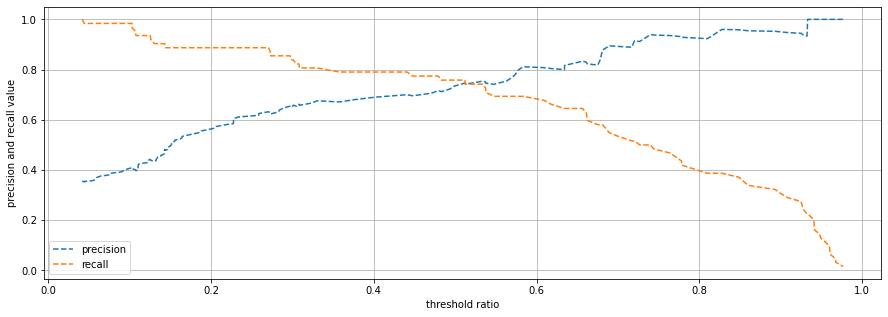

In [21]:
# 임계값이 1에 가까우면 TNR 커지고, FPR 작아진다. 
plt.figure(figsize=(15, 5))

plt.plot(threshold, precision[ 0:threshold.shape[0]], linestyle='--', label='precision')
plt.plot(threshold, recall[ 0:threshold.shape[0]], linestyle='--', label='recall')

plt.xlabel('threshold ratio')
plt.ylabel('precision and recall value')

plt.legend()
plt.grid()

plt.show()
plt.close()

#### 타이타닉 예제

In [22]:
pred_positive_label = logistic_model.predict_proba(X_test)[:, 1]
pred_positive_label.shape

(179,)

In [23]:
fprs, tprs, thresholds = roc_curve(y_test, pred_positive_label)

In [24]:
# 샘플 추출
thr_idx = np.arange(1, thresholds.shape[0], 6)
thr_idx

array([ 1,  7, 13, 19, 25, 31, 37, 43, 49, 55])

In [26]:
thresholds[thr_idx]

array([0.97697207, 0.72682315, 0.65648777, 0.51172271, 0.33020264,
       0.2969601 , 0.18767226, 0.12509561, 0.11010609, 0.02698788])

In [27]:
fprs[thr_idx]

array([0.        , 0.02564103, 0.06837607, 0.13675214, 0.20512821,
       0.23931624, 0.37606838, 0.62393162, 0.72649573, 1.        ])

In [28]:
tprs[thr_idx]

array([0.01612903, 0.5       , 0.64516129, 0.75806452, 0.80645161,
       0.85483871, 0.88709677, 0.93548387, 0.93548387, 1.        ])

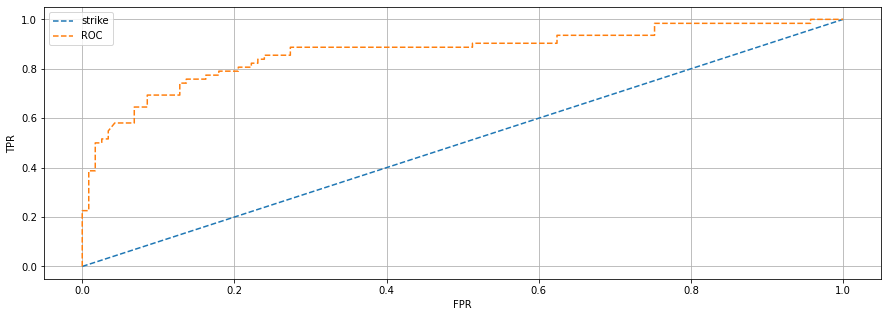

In [29]:
plt.figure(figsize=(15, 5))

plt.plot([0,1] , [0,1] , linestyle='--', label='strike')
plt.plot(fprs, tprs, linestyle='--', label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
plt.grid()

plt.show()
plt.close()

In [30]:
# AUC 성능평가 확인

def metrics_evaluation(y_test, y_pred):
    print("정확도(Accuracy) : {}\n정밀도(Precision) : {}\n재현율(Recall) : {}\n조화평균(F1) : {}\nAUC : {}"
         .format(accuracy_score(y_test, y_pred),
                 precision_score(y_test, y_pred),
                 recall_score(y_test, y_pred),
                 f1_score(y_test, y_pred),
                 roc_auc_score(y_test, y_pred)))

In [31]:
metrics_evaluation(y_test, y_pred)

정확도(Accuracy) : 0.8268156424581006
정밀도(Precision) : 0.746031746031746
재현율(Recall) : 0.7580645161290323
조화평균(F1) : 0.752
AUC : 0.8106561896884479
